# Project: Identify Customer Segments

In this project, we apply unsupervised learning techniques to identify segments from the population that form the core customer base for Bertelsmann Arvato Analytics (a mail-order sales company in Germany). These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected ROI.

There are four files associated with this project however due to having to sign an NDA I can't publish the actual data files to Github.  Below is what each of these files contained.

- 'azdias.csv': Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- 'customers.csv': Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- 'data_Dictionary.md': Detailed information file about the features in the provided datasets.
- 'feature_summary.csv': Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I used this information to cluster the general population into groups with similar demographic properties. Then I will look at how the people in the customers dataset fit into those clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [1]:
#Import standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
#Load in the general demographics data.
df_azdias = pd.read_csv('azdias.csv', sep=';')

#Load in the feature summary file.
df_feat_sum = pd.read_csv('feature_summary.csv', sep=';')

## Eploratory Data Analysis

In [3]:
#Explore the data and see what kind of shape it is in

missing = df_azdias.isnull().sum().sum()
print("The main dataset has %s rows, %s columns and %s missing values " %(df_azdias.shape[0], df_azdias.shape[1], missing))

print("The summary dataset has %s rows and %s columns"  %(df_feat_sum.shape[0], df_feat_sum.shape[1]))

The main dataset has 891221 rows, 85 columns and 4896838 missing values 
The summary dataset has 85 rows and 4 columns


In [4]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
df_feat_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [6]:
#Descriptive stats
df_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
df_feat_sum.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KBA05_ANTG4,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
df_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
df_feat_sum.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Preprocessing

The feature summary file contains a summary of for each demographics data column. I used this file to make preprocessing decisions.

The fourth column of the feature attributes summary documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this with numbers, we will replace it and fill it in appropriate NaN values.

We do this with the function below.

In [10]:
def clean_null(df_azdias):
    for x in range(len(df_feat_sum)):
        missing_or_unknown = df_feat_sum.iloc[x]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') 
                              else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_azdias = df_azdias.replace({df_feat_sum.iloc[x]['attribute']: missing_or_unknown}, np.nan)
     
    return df_azdias

df_azdias = clean_null(df_azdias)

missing_now = df_azdias.isnull().sum().sum()
missing_increase = (missing / missing_now) * 100
missing_increase_str = str(missing_increase)
print('The total number of missing values has changed from %s to %s which represents an increase of %s percent post function' 
      %(missing, missing_now, missing_increase_str[:5]))

The total number of missing values has changed from 4896838 to 8373929 which represents an increase of 58.47 percent post function


### Visually Assess Missing Data in Columns

In [11]:
print (len(df_azdias))
print (df_azdias.shape[0])

891221
891221


In [12]:
#Counts of how much data is missing in each row of df_azdias
missing_column_data = df_azdias.isnull().sum(axis=0);

#Create a proportion
prop_missing_column_data = missing_column_data/len(df_azdias)

The following functions allows us to visually assess missing data in each column.

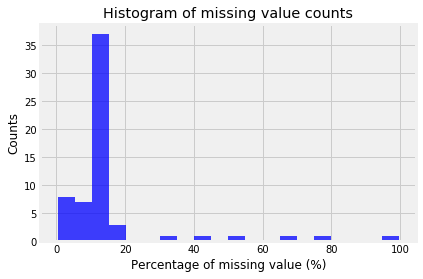

In [13]:
#Perform an assessment of the percentage of how how much missing data there is in each column of the dataset.

def missing_column_data_percent_plot(df_azidas):
    #Prep to plot
    missing = df_azdias.isnull().sum()
    missing = missing[missing > 0]/(df_azdias.shape[0]) * 100
    missing.sort_values(inplace=True)
    
    #Plot distribution of missing value counts
    plt.hist(missing, bins=20, facecolor='b', alpha=0.75)
    plt.xlabel('Percentage of missing value (%)')
    plt.ylabel('Counts')
    plt.title('Histogram of missing value counts')
    plt.grid(True)
    plt.show()
    
missing_column_data_percent_plot(df_azdias)

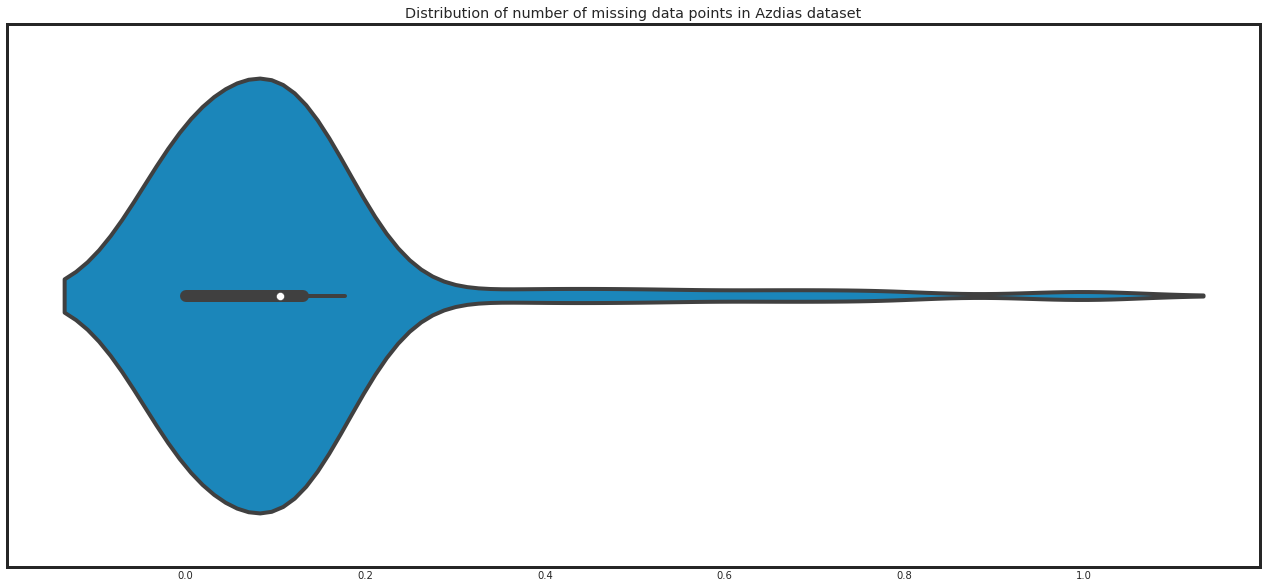

In [14]:
#Violin Plot
def violin_plot(df_azdias, plot_data):
    sns.set_style("ticks")
    fig = plt.figure(figsize=(20,10))
    ax = sns.violinplot(plot_data)
    ax.set_title("Distribution of number of missing data points in Azdias dataset")
    plt.show()

violin_plot(df_azdias, prop_missing_column_data)

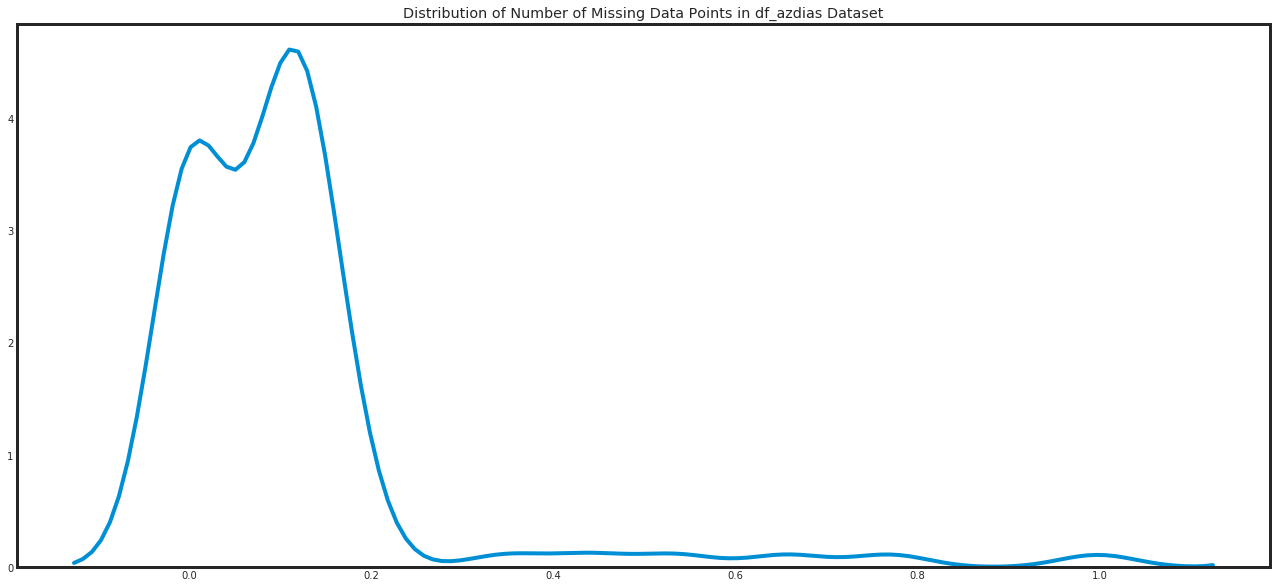

In [15]:
#KDE plot
def kde_plot(df_azdias, data):
    sns.set_style("ticks")
    fig = plt.figure(figsize=(20,10))
    ax = sns.kdeplot(data)
    ax.set_title("Distribution of Number of Missing Data Points in df_azdias Dataset")
    plt.show()
    
kde_plot(df_azdias, prop_missing_column_data)

We can see based on the 3 different graphs above that columns with more than 20% missing values are outliers. Next, let's investigate those columns and decide if we can drop them from the dataframe. 

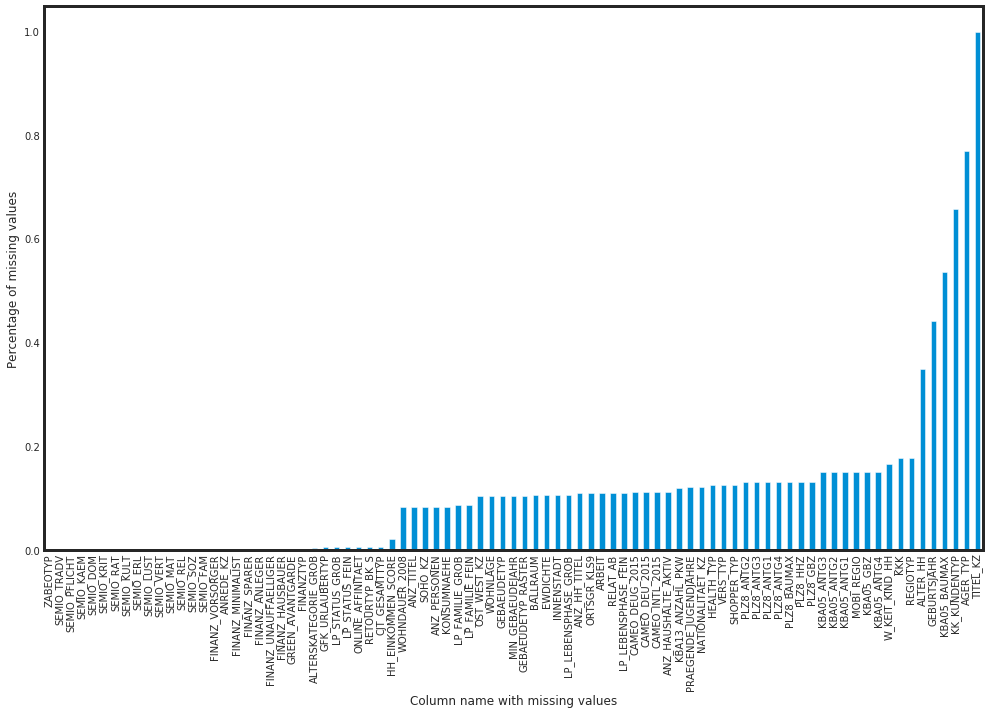

There are 85 columns with missing values.


In [16]:
def missing_data_by_column(df_azdias):
    prop_missing_column_data.sort_values(inplace=True)
    prop_missing_column_data.plot.bar(figsize=(15,10))
    plt.xlabel('Column name with missing values')
    plt.ylabel('Percentage of missing values')

    plt.show()
    print("There are %s columns with missing values." %(len(prop_missing_column_data)))

missing_data_by_column(df_azdias)

Based on all the charts from above we see that the most columns have fewer than 20% of missing data points. We will thus eliminate any column which has more than 20% of missing data points.

In [17]:
#The following columns are those we will drop: 
def drop_columns_greater_than_20(df_azdias):
    missing_greater_than_20 = [col for col in df_azdias.columns if (df_azdias[col].isnull().sum()/df_azdias.shape[0])
                               * 100 > 20]
    
    #See which columns are getting tossed
    print(missing_greater_than_20)
    
    #Begin dropping outlier columns
    for col in missing_greater_than_20:
        df_azdias.drop(col, axis=1, inplace=True)
    
drop_columns_greater_than_20(df_azdias)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


The columns with lots of missing data tended to be those of individual records, like people's titles, dates of birth, etc.

I removed six columns from the data: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

### Visually Assess Missing Data in Rows

This is very similar to what we did above for columns

In [18]:
#Counts of how much data is missing in each row of df_azdias
missing_row_data = df_azdias.isnull().sum(axis=1)

#Create a propotion
prop_missing_row_data = missing_row_data/df_azdias.shape[1]

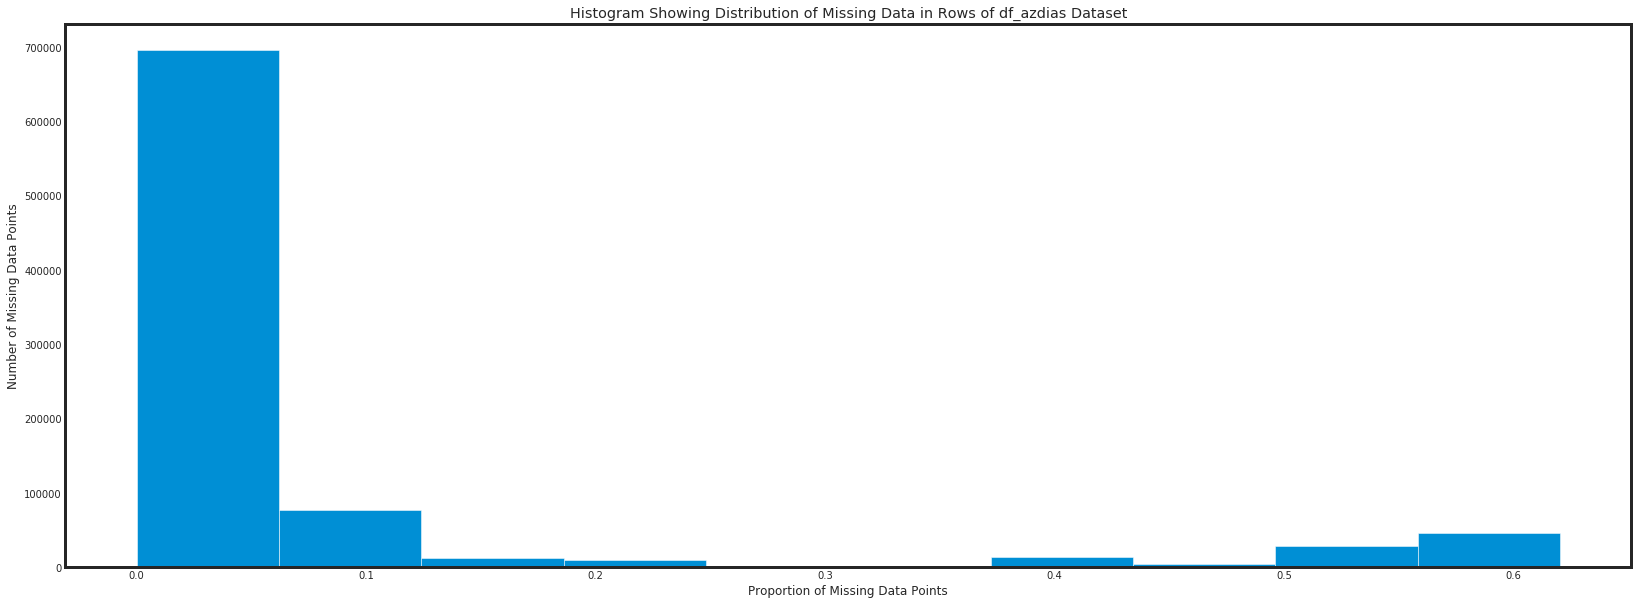

In [19]:
#Histogram to visualize & count proportions of missing data 
def missing_row_data_percent_plot(df_azdias):
    fig = plt.figure(figsize=(25,10))
    sns.set_style("ticks")
    ax = prop_missing_row_data.plot.hist()
    ax.set_title("Histogram Showing Distribution of Missing Data in Rows of df_azdias Dataset")
    ax.set_xlabel("Proportion of Missing Data Points")
    ax.set_ylabel("Number of Missing Data Points")
    plt.show()
    
missing_row_data_percent_plot(df_azdias)

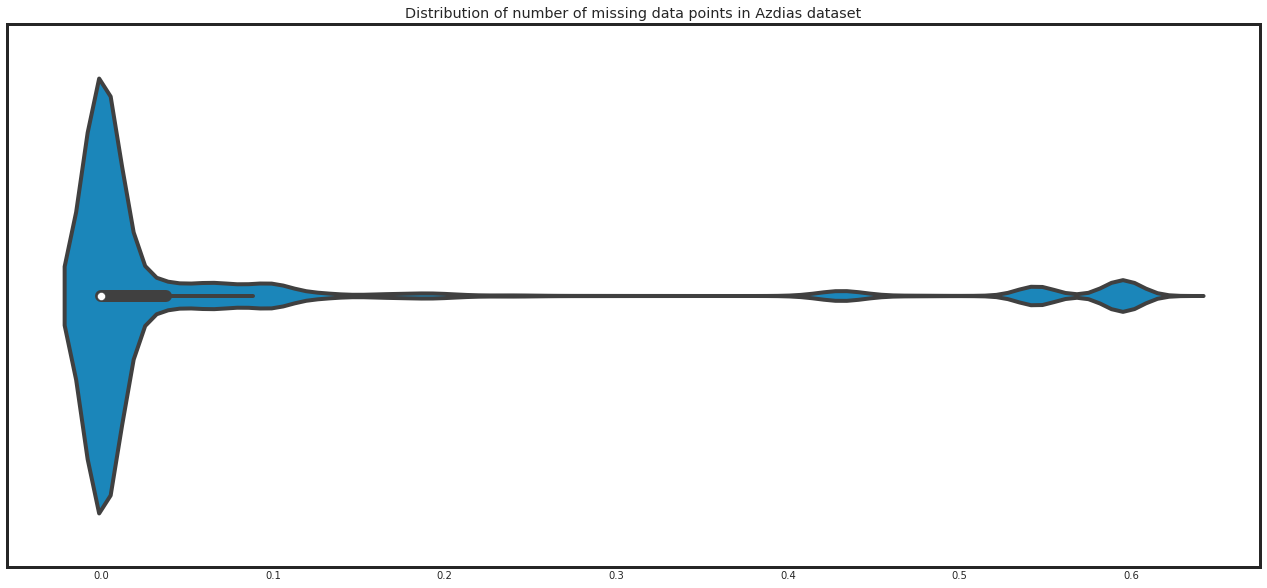

In [20]:
#Reubse our function from above
violin_plot(df_azdias, prop_missing_row_data)

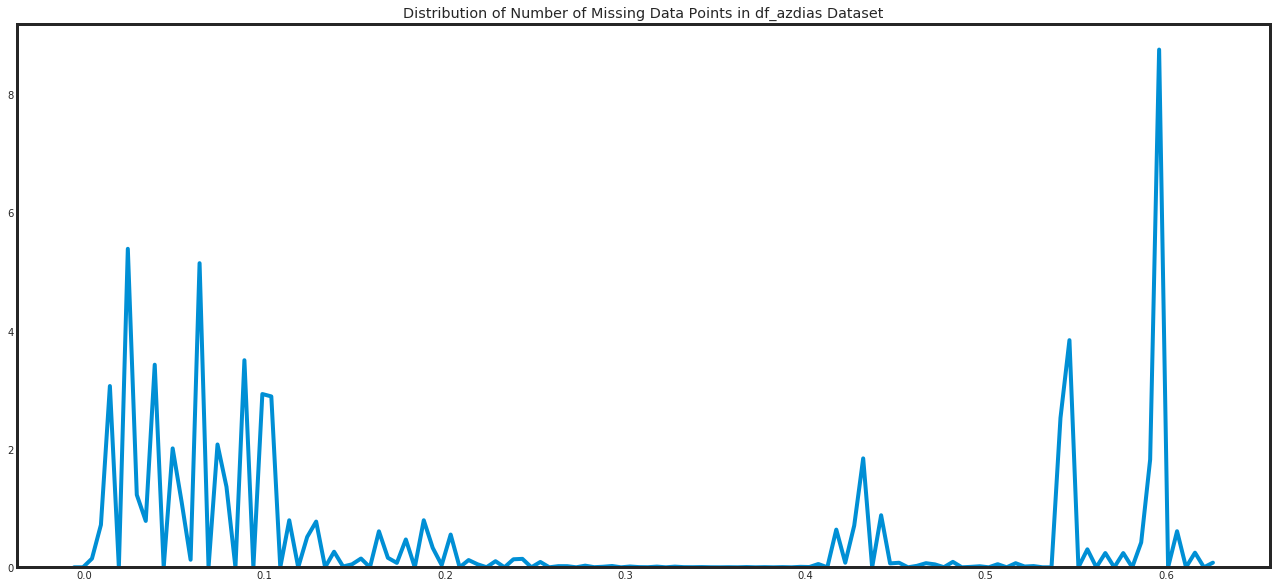

In [21]:
kde_plot(df_azdias, prop_missing_row_data)

Now we divide the dataset into two subsets based on the number of missing values in each row. The first dataset is comprised of rows with 3 or less missing values and the second dataset contains everything else.

In [22]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
df_azdias_less_than_3 = df_azdias[df_azdias.isnull().sum(axis=1) <= 3].reset_index(drop=True)
df_azdias_more_than_3 = df_azdias[df_azdias.isnull().sum(axis=1) > 3].reset_index(drop=True)

In [23]:
#See which random 5 columns we will choose for comparision
df_azdias_less_than_3.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distributions(feature):
    fig = plt.figure(figsize=(10,5))
    fig.suptitle("Comparison of datasets with missing values and datasets without missing values")
    plt.subplot(1,2,1)
    ax1 = sns.countplot(data = df_azdias_less_than_3, x=df_azdias_less_than_3[feature])
    ax1.set_xlabel("Values")
    ax1.set_ylabel("Counts")
    ax1.set_title("Dataset with 3 or fewer missing Values")
    plt.subplot(1,2,2)
    ax2 = sns.countplot(data=df_azdias_more_than_3, x=df_azdias_more_than_3[feature])
    ax2.set_title("Dataset with more than 3 missing values")
    ax2.set_xlabel("Values")
    ax2.set_ylabel("Counts")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.88, wspace=0.4)
    plt.show()

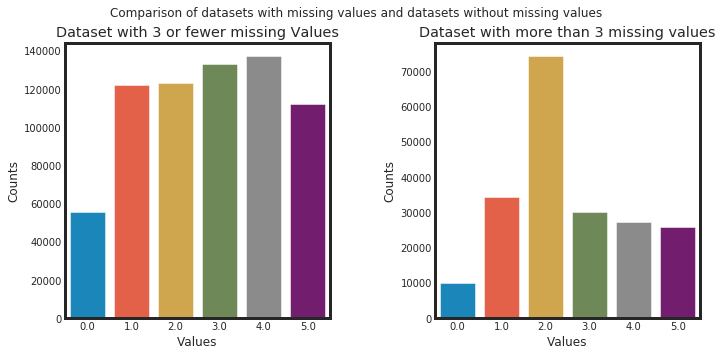

In [25]:
compare_distributions('ONLINE_AFFINITAET')

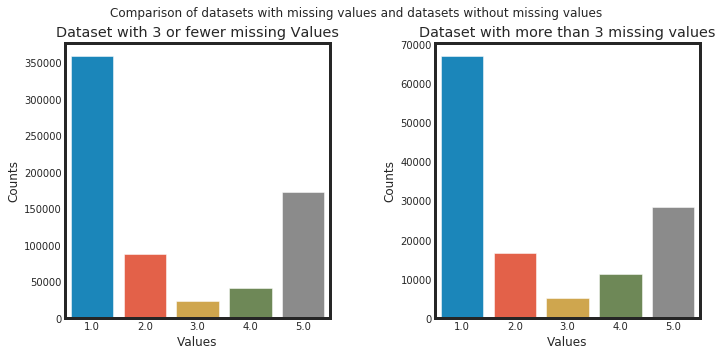

In [26]:
compare_distributions('LP_FAMILIE_GROB')

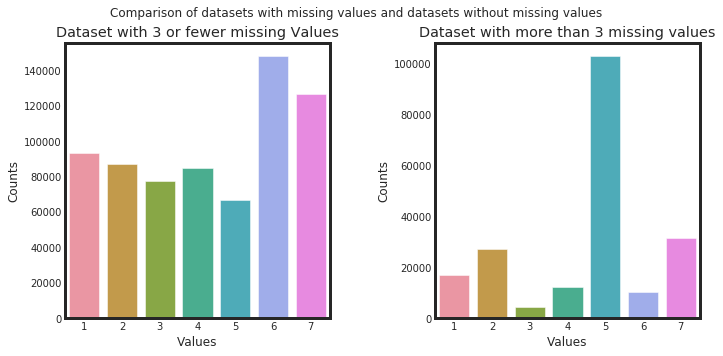

In [27]:
compare_distributions('SEMIO_LUST')

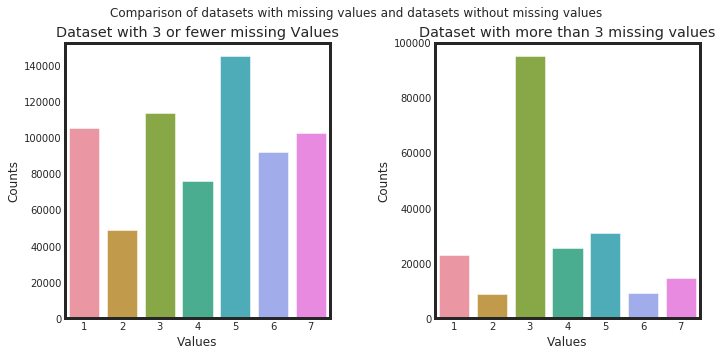

In [28]:
compare_distributions('SEMIO_KULT')

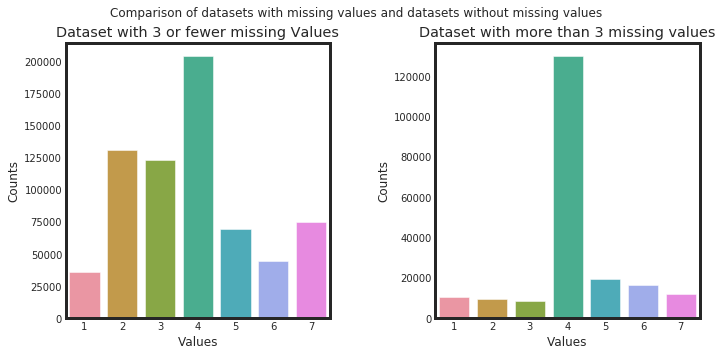

In [29]:
compare_distributions('SEMIO_RAT')

From the bar charts above, we can see the distributions of values between both datasets are different for some features. Thus, we will concentrate on the dataset with no missing values.

### Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [30]:
#How many features are there of each data type?
df_feat_sum['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [31]:
#Assess categorical variables: 
categorical_features = df_feat_sum[df_feat_sum["type"]=="categorical"]["attribute"]
df_categorical_features = pd.DataFrame()
def classify_features(df_azdias_less_than_3):
    features = []
    number_of_categories = []
    for feature in categorical_features: 
        if feature in list(df_azdias):
            features.append(feature)
            number_of_categories.append(len(df_azdias[feature].unique()))
        else:
            pass
    df_categorical_features['features'] = features
    df_categorical_features['number_of_categories'] = number_of_categories

      
classify_features(df_azdias_less_than_3)

##### Binary Categorical Variables:

In [32]:
#We use 3 because the nan's that haven't been removed still count as a value as evidenced below in OST_WEST_KZ
df_categorical_features.query('number_of_categories <= 3')

,features,number_of_categories
0,ANREDE_KZ,2
4,GREEN_AVANTGARDE,2
11,SOHO_KZ,3
12,VERS_TYP,3
15,OST_WEST_KZ,3


In [33]:
#Values...  This is binary but needs to be re-encoded since it uses non-numeric values ('W' for West and 'O' for East).
df_azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [35]:
#Function to re-encode into a binary categorical
def fix_ost_west_kz(df_azdias_less_than_3):
    new_values = {'W': 1, 'O': 0}
    df_azdias.replace({'OST_WEST_KZ':{'W': 1, 'O': 0}}, inplace=True)
    
fix_ost_west_kz(df_azdias_less_than_3)

In [36]:
df_azdias_less_than_3['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

##### Multi-level variables

In [37]:
df_categorical_features.query('number_of_categories > 3')

,features,number_of_categories
1,CJT_GESAMTTYP,7
2,FINANZTYP,6
3,GFK_URLAUBERTYP,13
5,LP_FAMILIE_FEIN,12
6,LP_FAMILIE_GROB,6
7,LP_STATUS_FEIN,11
8,LP_STATUS_GROB,6
9,NATIONALITAET_KZ,4
10,SHOPPER_TYP,5
13,ZABEOTYP,6


### Discussion
From looking at the description in the data dictionary of the remaining categorical features in the dataset, I came to the
following conclusions:

'CACAMEO_DEUG_2015' and 'CAMEO_DEU_2015' at different scales both describe the wealth and life stage.  I will keep
'CAMEO_DEUG_2015', that which describes the typology at the rough scale.

The same is true of 'LP_FAMILIE_FEIN' / 'LP_FAMILIE_GROB' and 'LP_STATUS_FEIN' / 'LP_STATUS_GROB'.
I also drop 'GEBAEUDETYP', which is a building-level feature, which simply describes the types of buildings and probably
has no value going forward.

After I drop the un-needed columns we will one-hot-encode the rest of the categorical variables

In [38]:
categorical_columns_to_drop =['CAMEO_DEU_2015','LP_STATUS_FEIN','LP_FAMILIE_FEIN', 'GEBAEUDETYP']

df_azdias_less_than_3 = pd.get_dummies(df_azdias_less_than_3, columns=['NATIONALITAET_KZ', 'CJT_GESAMTTYP', 
                                                                       'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB',
                                                                       'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 
                                                                       'CAMEO_DEUG_2015'])

#### Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [39]:
# "PRAEGENDE_JUGENDJAHRE" engineer two new variables:
def praegende_jugendjahre(df_azdias_less_than_3):
    df_azdias_less_than_3['praegende_jugendjahre_decade'] = df_azdias_less_than_3['PRAEGENDE_JUGENDJAHRE']
    df_azdias_less_than_3['praegende_jugendjahre_movement'] = df_azdias_less_than_3['PRAEGENDE_JUGENDJAHRE']
    decade_replacement_dictionary = {2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df_azdias_less_than_3['praegende_jugendjahre_decade'].replace(decade_replacement_dictionary, inplace=True)
    movement_replacement_dictionary = {3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
    df_azdias_less_than_3['praegende_jugendjahre_movement'].replace(movement_replacement_dictionary, inplace=True)

praegende_jugendjahre(df_azdias_less_than_3)

In [40]:
# "CAMEO_INTL_2015"  engineer two new variables:
def cameo_intl_2015(df_azdias_less_than_3):
    wealth_dictionary = {}
    lifestage_dictionary = {}
    for i in range (1,6):
        for j in range(1,6):
            key = str(i * 10 + j)
            wealth_dict[key] = i
            lifestage_dict[key] = j
    df_azdias_less_than_3['cameo_intl_2015_wealth'] = df_azdias_less_than_3['CAMEO_INTL_2015'].replace(wealth_dictionary)
    df_azdias_less_than_3['cameo_intl_2015_life_stage'] = df_azdias_less_than_3['CAMEO_INTL_2015'].replace(lifestage_dictionary)       